In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import l1_min_c
from sklearn.metrics import roc_curve, auc
sns.set_context('talk')
sns.set_style('darkgrid')
sns.set_palette('colorblind')

This tutorial shows how one might perform data cleaning, eda, and classification for a simple dataset.  

We'll be using a dataset of the passengers of the titanic to predict their likelihood of survival

# Variable description table from [Kaggle](https://www.kaggle.com/c/titanic/data)

| variable name      | description           | encoding  |
| :-------------: |:-------------:| :-----:|
|survival |Survival | 0 = No, 1 = Yes |
|pclass |Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
|sex| Sex | | 
|Age |Age in years | |
|sibsp | # of siblings / spouses aboard the Titanic | |
|parch | # of parents / children aboard the Titanic | | 
|fare | Passenger fare | | 
|embarked |Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton | 

I am loading the titanic data

In [33]:
# I am loading the titanic data here 
titanic = sns.load_dataset('titanic')

In [34]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


Let's see what percent of each variable is missing

Text(0.5, 1.0, 'Percent Missing by Variable')

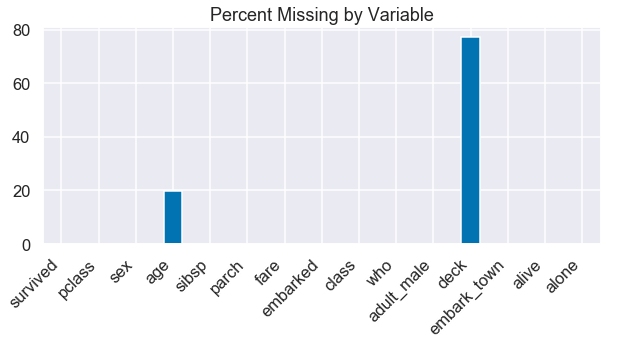

In [4]:
f, ax = plt.subplots(figsize=(10,4))
((titanic.isnull().sum()/len(titanic)) * 100).plot(kind='bar')
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Percent Missing by Variable')

Given the amount of missing data, we can get rid of `deck`

Let's try to explore `who` to see if we can get a good proxy for age

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

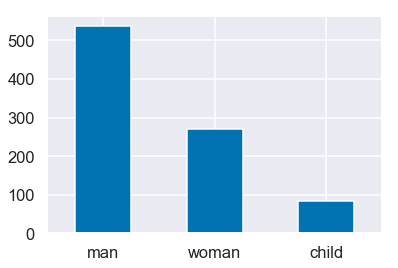

In [5]:
titanic.who.value_counts().plot(kind='bar')
plt.xticks(rotation=0, horizontalalignment='center')

We can then make variables for children and gender.  Because there are only adults and children, men and women, we will create a variable for children and ignore children

In [35]:
titanic['child'] = titanic['who'] == 'child'

In [36]:
titanic['male'] = titanic['sex'] == 'male'

We can also turn `embark_town` into dummy variables. We will have to drop one of them since we only need $n-1$ out of the $n$ categories to represent our data. 

In [37]:
titanic = pd.concat([titanic, pd.get_dummies(titanic.embark_town, drop_first=True)], axis=1)

In [38]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,child,male,Queenstown,Southampton
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False,False,True,0,1
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False,False,False,0,0
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True,False,False,0,1
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False,False,False,0,1
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True,False,True,0,1


Now we can specify our training and our test data with `train_test_split`

We'll be using `adult_male` `alone` `child` `male`, `fare` `pclass` `sibsp` `Queenstown` and `Southampton` because they are now numerically coded and are similar to variables that we have not turned into numerical data.

We'll be using $20\%$ of the data as test data

In [66]:
training_variables = ['adult_male', 'alone', 'child', 'fare', 'pclass', 'sibsp', 'parch', 'Queenstown', 'Southampton']

X_train, X_test, y_train, y_test = train_test_split(titanic[training_variables],
                 titanic['survived'], test_size=0.2)

Instead of training a single model, we'll train multiple models with different parameter settings to figure out which one will give us the best perforamnce.

There are many ways of selecting parameters.  In this example, we select them by randomly sampling parameter values and figuring out which one performs best using cross validation. 

When we cross validate, we vary the train and test set to see which model typically performs best.

We'll first try modeling our data with a random forest. A random forest uses multiple decision trees to model data.  Decision trees partition the data based on a learned set of conditions

![alt text](https://upload.wikimedia.org/wikipedia/commons/f/f3/CART_tree_titanic_survivors.png)

In this example, we'll be testing to find:

- `n_estimators`: the number of decision trees
- `max_features`: max number of columns to use in each tree
- `min_samples_split`: numbers of rows to use when splitting the data
- `bootstrap`: method of sampling the data to train our model
- `criterion`: method of selecting a how to split the data 

To learn more about each parameter and its meaning, you can read the documentation for the `RandomForestClassifier` on [scikit-learn's webiste](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

We will try `n_iter=20` different versions of our model.  To select the best model, we train `cv=5` versions of each model and calucate the average accuracy.  The model with the highest average accuracy will be used.

To get our model to show us updates, we're setting `verbose=1` and will speed up our work by setting `n_jobs=-1`

In [67]:
rf = RandomForestClassifier()
param_dist = {"n_estimators": stats.randint(2, 300),
              "max_features": ['sqrt',  'log2'],
              "min_samples_split": stats.randint(5, 50),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
random_rf = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=20, cv=10, verbose=1, n_jobs=-1)
random_rf.fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.9min finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1b47fac8>, 'max_features': ['sqrt', 'log2'], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1b47f400>, 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=1

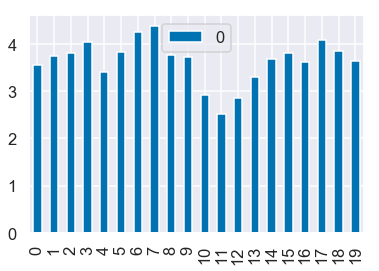

In [68]:
pd.DataFrame(random_rf.cv_results_['std_test_score'] * 100).plot(kind='bar') 

Let's plot our models to see how they perform. We'll plot their average accuracy on the the portion of data used for training and the portion they used for testing.

Because the selection of models is random, we won't get the same plot each time. However, training performance is always less than test performance

/Users/forde/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


Text(0.5, 1.0, 'Average Accuracy for Train and Test Data')

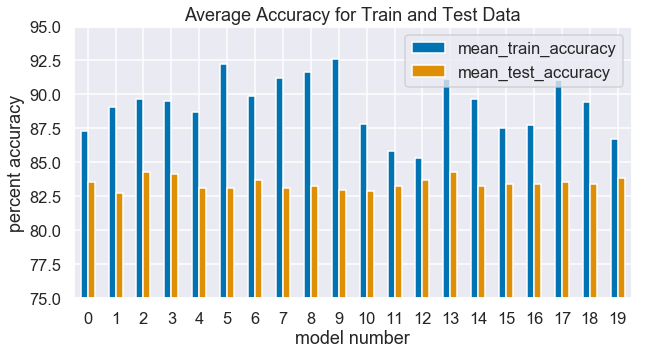

In [69]:
train_test_results = pd.DataFrame([random_rf.cv_results_['mean_train_score'],
                                   random_rf.cv_results_['mean_test_score']]).T * 100
train_test_results.columns = ['mean_train_accuracy', 'mean_test_accuracy']
f, ax = plt.subplots(figsize=(10,5))
train_test_results.plot(kind='bar', ax=ax)
plt.xticks(rotation=0, horizontalalignment='center')
plt.legend(loc=0)
plt.ylim(75, 95)
plt.xlabel('model number')
plt.ylabel('percent accuracy')
plt.title('Average Accuracy for Train and Test Data')

We'll also plot the difference between train and test performance here.  

Text(0.5, 1.0, 'Difference in Test Accuracy Compared Train Accuracy')

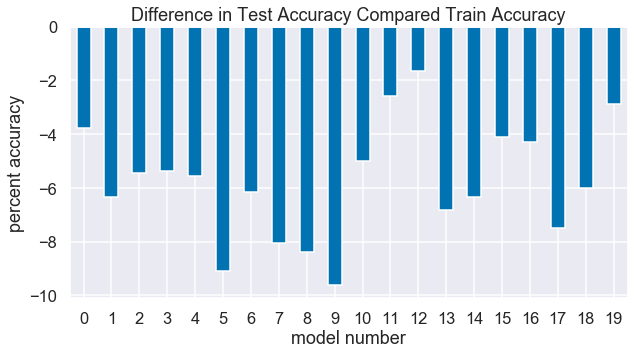

In [70]:
f, ax = plt.subplots(figsize=(10,5))
pd.DataFrame(train_test_results['mean_test_accuracy'] - train_test_results['mean_train_accuracy'])\
.plot(kind='bar', ax=ax)
plt.xticks(rotation=0, horizontalalignment='center')
ax.get_legend().remove()
plt.xlabel('model number')
plt.ylabel('percent accuracy')
plt.title('Difference in Test Accuracy Compared Train Accuracy')

We can get the best model and learn about its parameter settings and find its average accuracy

In [51]:
random_rf.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features='log2',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=28, min_weight_fraction_leaf=0.0,
            n_estimators=238, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [71]:
random_rf.best_score_ 

0.8426966292134831

We can also see how the model performs to our hold-out data 

In [72]:
random_rf.score(X_test, y_test)

0.7430167597765364

In [74]:
random_rf.best_estimator_.predict_proba(np.array([[False, False, False, 40, 1, 1, 1, 0, 0]]))

array([[0.03792073, 0.96207927]])

We can also measure the relative importance of each variable in our model.  The feature importances used in this method are described in the documentation [here](https://scikit-learn.org/stable/modules/ensemble.html#feature-importance-evaluation) and describes the relative imporance each feature plays in chaning the value of the `criterion` you use to fit each tree in your random forest.

Because these numbers are normalized, the importances sum to $1$

For the majority of these models, `adult_male` is the top varaible.  This is understandable because at the time, people believed in "women and children first."  However, this does not explain if each variable would increase or decrease the likelihood of surviving.

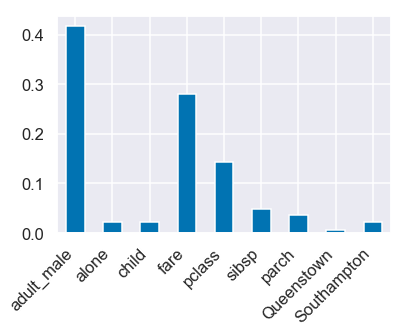

In [75]:
ax = pd.DataFrame(random_rf.best_estimator_.feature_importances_).plot(kind='bar')
ax.set_xticklabels(training_variables, rotation = 45, ha="right")
ax.get_legend().remove()

Text(0.5, 1.0, 'ROC Curve for Random Forest, AUC = 0.7852')

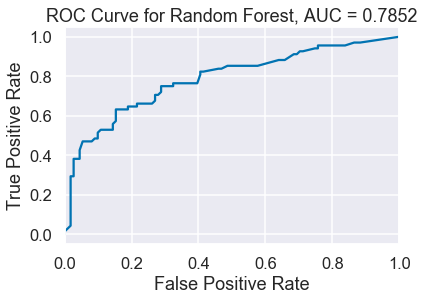

In [76]:
auc_data = pd.DataFrame(roc_curve(y_test, random_rf.best_estimator_.predict_proba(X_test)[:,1])).T
auc_data.columns = ['False Positive Rate', 'True Positive Rate', 'Thresholds'] 
ax = auc_data.plot(x='False Positive Rate', y='True Positive Rate')
ax.get_legend().remove()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest, AUC = %0.4f' % auc(auc_data['False Positive Rate'], auc_data['True Positive Rate']))

We're going to compare this to a more interpretable model, a logistic regression. A logistic regression uses a linear function to model the probability that an observation is in a particular category using the sigmoid function:


<img src="https://hvidberrrg.github.io/deep_learning/activation_functions/assets/sigmoid_function.png" width="500">


Where 

# $$\sigma({x}) = \frac{1}{1+e^{x\beta}}$$

In the plot above, x is 1 dimensional, models with larger numbers of variables would take the shape of a plane or hyperplane with a similar shape:

<img src="https://i.stack.imgur.com/bd9vv.png" width="500">


This model also outputs a probability, since the output of a sigmoid function is between 0 and 1.  

Because this model is linear, it's important to regularize your model and/or explicitly exclude variables that are highly correlated.

For example, we excluded out one of the dummy variables when we constructed the dummy variables for `embark_town` because it was a linear combination of the other dummy variables. 

To regularize our model, we'll be using $\ell_1$ regularization, also known as Lasso regularization, which places a penalty on the absolute value of the parameters $\beta$ relative to its absolute value. In effect, this means more of our model parameters will be equal to $0$.

To control, the strength of our regularization, we use the regularization parameter $C$.

We will vary this parameter to see how the model changes.



In [77]:
l1_min_c(X_train, y_train, loss='log', fit_intercept=True, intercept_scaling=1.0)

0.0004865157892009794

In [78]:
c_values = np.geomspace(0.001, 100, num = 6)

In [79]:
parameters = ParameterGrid({'solver':['liblinear', 'saga'], 'C':c_values})
lr = LogisticRegression(penalty='l1', random_state=0, max_iter=5000, verbose=1, n_jobs=-1)
lr_models = pd.DataFrame(parameters)
betas = []
accuracy = []
for p in parameters:
    lr.set_params(**p)
    lr.fit(X_train, y_train)
    betas.append(lr.coef_.ravel())
    accuracy.append(lr.score(X_train, y_train))

/Users/forde/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


[LibLinear]convergence after 566 epochs took 7 seconds
[LibLinear]

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.8s finished
/Users/forde/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 7 seconds
[LibLinear]

/Users/forde/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.5s finished
/Users/forde/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 3808 epochs took 4 seconds
[LibLinear]

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.2s finished
/Users/forde/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 3984 epochs took 3 seconds
[LibLinear]

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s finished
/Users/forde/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 4009 epochs took 6 seconds
[LibLinear]

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.0s finished
/Users/forde/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 4011 epochs took 5 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.7s finished


Text(0.5, 0, 'C')

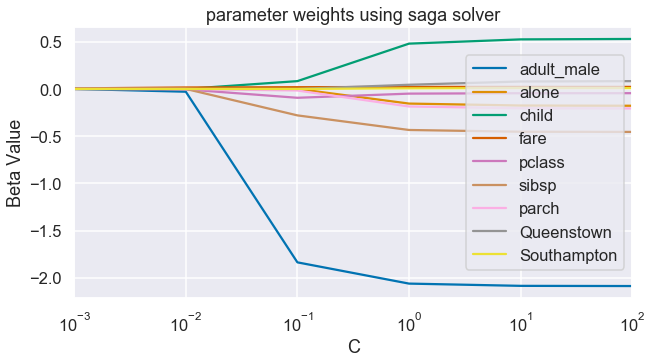

In [80]:
f, ax = plt.subplots(figsize=(10,5))
lr_data = pd.concat([lr_models, pd.DataFrame(betas, columns = training_variables)], axis=1)
lr_data[lr_data['solver'] == 'saga'].set_index('C')[training_variables].plot(logx=True, ax=ax)
plt.title('parameter weights using saga solver')
plt.ylabel('Beta Value')
plt.xlabel('C')

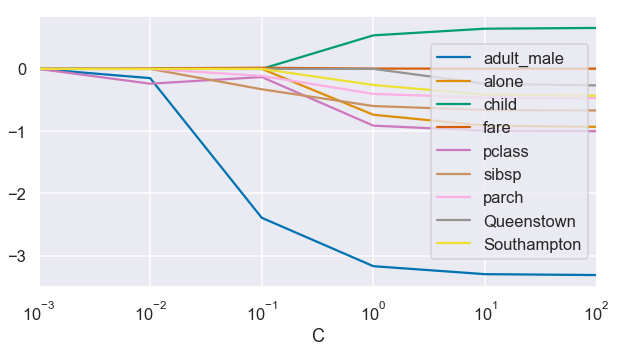

In [81]:
f, ax = plt.subplots(figsize=(10,5))
lr_data = pd.concat([lr_models, pd.DataFrame(betas, columns = training_variables)], axis=1)
lr_data[lr_data['solver'] == 'liblinear'].set_index('C')[training_variables].plot(logx=True, ax=ax)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


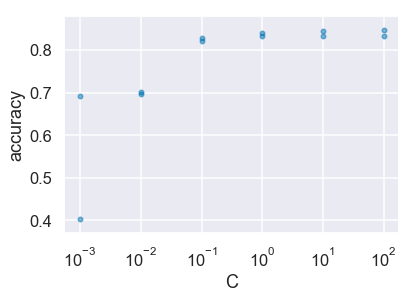

In [82]:
lr_data['accuracy'] = accuracy
lr_data.plot.scatter(x='C', y='accuracy', logx=True, alpha=0.5)

In [83]:
lr.score(X_test, y_test)

0.7597765363128491

Text(0.5, 1.0, 'Logistic Regression Model Parameters')

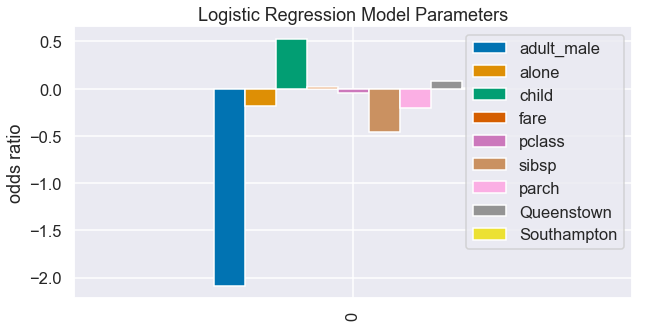

In [84]:
f, ax = plt.subplots(figsize=(10,5))
pd.DataFrame(lr.coef_, columns=training_variables).plot(kind='bar', ax=ax)
plt.ylabel('odds ratio')
plt.xlabel('')
plt.title('Logistic Regression Model Parameters')

Text(0, 0.5, 'True Positive Rate')

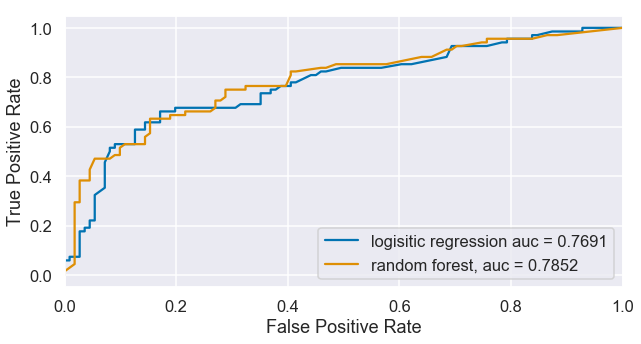

In [85]:
auc_data_lr = pd.DataFrame(roc_curve(y_test, lr.predict_proba(X_test)[:,1])).T
auc_data_lr.columns = ['False Positive Rate', 'True Positive Rate', 'Thresholds'] 
f, ax = plt.subplots(figsize=(10,5))
auc_data_lr.plot(x='False Positive Rate', y='True Positive Rate', ax=ax,
                 label='logisitic regression auc = %0.4f' % auc(auc_data_lr['False Positive Rate'], auc_data_lr['True Positive Rate']))
auc_data.plot(x='False Positive Rate', y='True Positive Rate', ax=ax,
              label='random forest, auc = %0.4f' % auc(auc_data['False Positive Rate'], auc_data['True Positive Rate']))
ax.get_legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [86]:
len(titanic)

891